# CNN

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import warnings
import itertools
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical




print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
!nvidia-smi

Num GPUs Available: 1
Thu Feb 13 10:50:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   50C    P8             17W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------------------------

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [36]:
file_path = "/content/drive/MyDrive/Colab Notebooks/AAI-530/Final Project/aai-530-iot-smart-house/Data/Final_Combined_Data.csv"

df = pd.read_csv(file_path)

df.head()

,DateTime,RH (%),eCO₂ (ppm),Inside Dew Point - °C,Inside Heat Index - °C,Barometer - mb,Inside Temp - °C,Sensor
0,2022-12-31 23:53:24,73.0,518.0,6.9,12.3,1002.6,12.3,EcoLab Ground
1,2023-01-01 00:00:00,68.0,518.0,8.0,13.0,1002.6,13.0,WeatherLink
2,2023-01-01 00:00:55,73.0,520.0,7.0,12.4,1002.6,12.4,EcoLab Ground
3,2023-01-01 00:08:23,73.0,505.0,7.0,12.4,1002.6,12.4,EcoLab Ground
4,2023-01-01 00:15:00,68.0,505.0,8.0,13.0,1002.7,13.0,WeatherLink


In [37]:
# Convert 'DateTime' column to datetime format
df["DateTime"] = pd.to_datetime(df["DateTime"], errors="coerce")

# Verify conversion
df.info()  # Check if 'DateTime' is now datetime64[ns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112622 entries, 0 to 112621
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   DateTime                112622 non-null  datetime64[ns]
 1   RH (%)                  112622 non-null  float64       
 2   eCO₂ (ppm)              112622 non-null  float64       
 3   Inside Dew Point - °C   112622 non-null  float64       
 4   Inside Heat Index - °C  112622 non-null  float64       
 5   Barometer - mb          112622 non-null  float64       
 6   Inside Temp - °C        112622 non-null  float64       
 7   Sensor                  112622 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 6.9+ MB


In [45]:
# Define the range
start_date = "2023-06-01"
end_date = "2023-11-30"

# Filter the DataFrame
df_filtered = df[(df["DateTime"] >= start_date) & (df["DateTime"] <= end_date)].copy()

# Verify the filtering
print(df_filtered["DateTime"].min(), "to", df_filtered["DateTime"].max())  # Confirm date range
print(df_filtered.shape)  # Check new dimensions

2023-06-01 00:00:00 to 2023-11-30 00:00:00
(65706, 8)


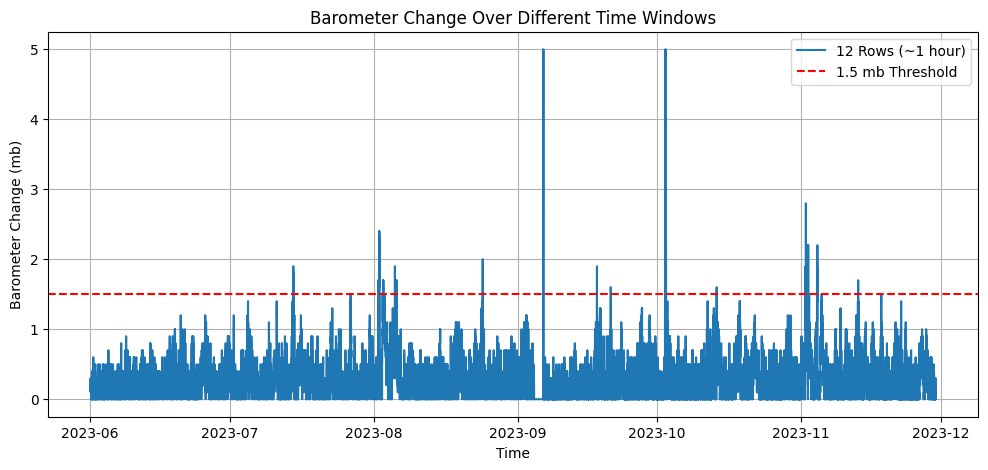

In [46]:
# Test different window sizes
#df_filtered["Barometer Change (5 Rows)"] = df_filtered["Barometer - mb"].diff(periods=5).abs()
#df_filtered["Barometer Change (6 Rows)"] = df_filtered["Barometer - mb"].diff(periods=6).abs()
df_filtered["Barometer Change (12 Rows)"] = df_filtered["Barometer - mb"].diff(periods=12).abs()

# Plot different window sizes
plt.figure(figsize=(12, 5))
#plt.plot(df_filtered["DateTime"], df_filtered["Barometer Change (5 Rows)"], label="5 Rows (~15 min)")
#plt.plot(df_filtered["DateTime"], df_filtered["Barometer Change (6 Rows)"], label="6 Rows (~30 min)")
plt.plot(df_filtered["DateTime"], df_filtered["Barometer Change (12 Rows)"], label="12 Rows (~1 hour)")
plt.axhline(y=1.5, color="red", linestyle="dashed", label="1.5 mb Threshold")
plt.xlabel("Time")
plt.ylabel("Barometer Change (mb)")
plt.title("Barometer Change Over Different Time Windows")
plt.legend()
plt.grid(True)
plt.show()


In [47]:
import numpy as np

# Create a new 'Label' column and set default to Comfortable (0)
df_filtered["Label"] = 0

# Apply Humid condition (1)
df_filtered.loc[(df_filtered["RH (%)"] > 70) | (df_filtered["Inside Heat Index - °C"] > 26), "Label"] = 1

# Apply Dry condition (2)
df_filtered.loc[(df_filtered["RH (%)"] < 35) | (df_filtered["Inside Dew Point - °C"] < 5), "Label"] = 2

# Compute Barometric Pressure Change over a rolling 12-row (~1 hour) window
df_filtered["Barometer Change"] = df_filtered["Barometer - mb"].diff().abs()
df_filtered["Unstable"] = df_filtered["Barometer Change"].rolling(window=12).sum() > 1.5  # Check if sum exceeds 1.5 mb in 1 hour

# Apply Unstable condition (3) based on the rolling window check
df_filtered.loc[df_filtered["Unstable"], "Label"] = 3

# Drop the intermediate columns (not needed for CNN training)
df_filtered.drop(columns=["Barometer Change", "Unstable", "Barometer Change (12 Rows)"], inplace=True)

# Verify label distribution
print(df_filtered["Label"].value_counts())

# Display the updated DataFrame
df_filtered.head(25)


Label
0    46704
1    15130
2     3315
3      557
Name: count, dtype: int64


,DateTime,RH (%),eCO₂ (ppm),Inside Dew Point - °C,Inside Heat Index - °C,Barometer - mb,Inside Temp - °C,Sensor,Label
37338,2023-06-01 00:00:00,41.0,497.0,8.0,20.0,1026.4,21.0,WeatherLink,0
37339,2023-06-01 00:00:23,49.0,513.0,9.4,19.6,1026.4,19.6,EcoLab Ground,0
37340,2023-06-01 00:07:56,49.0,492.0,9.4,19.6,1026.4,19.6,EcoLab Ground,0
37341,2023-06-01 00:15:00,41.0,492.0,8.0,20.0,1026.5,21.0,WeatherLink,0
37342,2023-06-01 00:15:25,49.0,505.0,9.3,19.5,1026.5,19.5,EcoLab Ground,0
37343,2023-06-01 00:22:56,49.0,513.0,9.3,19.5,1026.5,19.5,EcoLab Ground,0
37344,2023-06-01 00:30:00,41.0,513.0,8.0,20.0,1026.4,21.0,WeatherLink,0
37345,2023-06-01 00:30:24,49.0,527.0,9.3,19.5,1026.4,19.5,EcoLab Ground,0
37346,2023-06-01 00:37:56,49.0,510.0,9.3,19.5,1026.4,19.5,EcoLab Ground,0
37347,2023-06-01 00:45:00,41.0,510.0,8.0,20.0,1026.3,21.0,WeatherLink,0


In [48]:
# Extract time-based features
df_filtered["hour"] = df_filtered["DateTime"].dt.hour
df_filtered["day_of_week"] = df_filtered["DateTime"].dt.dayofweek  # Monday = 0, Sunday = 6
df_filtered["month"] = df_filtered["DateTime"].dt.month

# Convert hour, day_of_week, and month into cyclical features
df_filtered["hour_sin"] = np.sin(2 * np.pi * df_filtered["hour"] / 24)
df_filtered["hour_cos"] = np.cos(2 * np.pi * df_filtered["hour"] / 24)

df_filtered["day_sin"] = np.sin(2 * np.pi * df_filtered["day_of_week"] / 7)
df_filtered["day_cos"] = np.cos(2 * np.pi * df_filtered["day_of_week"] / 7)

df_filtered["month_sin"] = np.sin(2 * np.pi * df_filtered["month"] / 12)
df_filtered["month_cos"] = np.cos(2 * np.pi * df_filtered["month"] / 12)

# Drop the original DateTime, hour, day_of_week, and month columns
df_filtered.drop(["hour", "day_of_week", "month", "eCO₂ (ppm)", "Sensor"], axis=1, inplace=True)



In [49]:
# Drop DateTime after label creation
df_filtered.drop(columns=["DateTime"], inplace=True)

# Display the first few rows after feature extraction
df_filtered.head(25)


,RH (%),Inside Dew Point - °C,Inside Heat Index - °C,Barometer - mb,Inside Temp - °C,Label,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
37338,41.0,8.0,20.0,1026.4,21.0,0,0.000000,1.000000,0.433884,-0.900969,1.224647e-16,-1.0
37339,49.0,9.4,19.6,1026.4,19.6,0,0.000000,1.000000,0.433884,-0.900969,1.224647e-16,-1.0
37340,49.0,9.4,19.6,1026.4,19.6,0,0.000000,1.000000,0.433884,-0.900969,1.224647e-16,-1.0
37341,41.0,8.0,20.0,1026.5,21.0,0,0.000000,1.000000,0.433884,-0.900969,1.224647e-16,-1.0
37342,49.0,9.3,19.5,1026.5,19.5,0,0.000000,1.000000,0.433884,-0.900969,1.224647e-16,-1.0
37343,49.0,9.3,19.5,1026.5,19.5,0,0.000000,1.000000,0.433884,-0.900969,1.224647e-16,-1.0
37344,41.0,8.0,20.0,1026.4,21.0,0,0.000000,1.000000,0.433884,-0.900969,1.224647e-16,-1.0
37345,49.0,9.3,19.5,1026.4,19.5,0,0.000000,1.000000,0.433884,-0.900969,1.224647e-16,-1.0
37346,49.0,9.3,19.5,1026.4,19.5,0,0.000000,1.000000,0.433884,-0.900969,1.224647e-16,-1.0
37347,41.0,8.0,20.0,1026.3,21.0,0,0.000000,1.000000,0.433884,-0.900969,1.224647e-16,-1.0


In [71]:
# Define features (X) and target (y)
X = df_filtered.drop(columns=["Label"])  # Keep all features except 'Label'
y = df_filtered["Label"]  # Classification target

# Apply MinMax scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Fit on training data

# Convert back to DataFrame (optional, for verification)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Verify scaling
print(X_scaled_df.describe())


             RH (%)  Inside Dew Point - °C  Inside Heat Index - °C  \
count  65706.000000           65706.000000            65706.000000   
mean       0.412672               0.500175                0.388976   
std        0.108537               0.181141                0.191790   
min        0.000000               0.000000                0.000000   
25%        0.347826               0.356481                0.220779   
50%        0.417391               0.509259                0.424242   
75%        0.486957               0.648148                0.523810   
max        1.000000               1.000000                1.000000   

       Barometer - mb  Inside Temp - °C      hour_sin      hour_cos  \
count    65706.000000      65706.000000  65706.000000  65706.000000   
mean         0.731021          0.419461      0.501552      0.500671   
std          0.156883          0.187671      0.353667      0.353441   
min          0.000000          0.000000      0.000000      0.000000   
25%          0

In [83]:
X_scaled_df.head()

,RH (%),Inside Dew Point - °C,Inside Heat Index - °C,Barometer - mb,Inside Temp - °C,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,0.295652,0.324074,0.264069,0.942029,0.321267,0.5,1.0,0.722521,5.551115e-17,1.0,0.0
1,0.434783,0.388889,0.246753,0.942029,0.257919,0.5,1.0,0.722521,5.551115e-17,1.0,0.0
2,0.434783,0.388889,0.246753,0.942029,0.257919,0.5,1.0,0.722521,5.551115e-17,1.0,0.0
3,0.295652,0.324074,0.264069,0.943347,0.321267,0.5,1.0,0.722521,5.551115e-17,1.0,0.0
4,0.434783,0.384259,0.242424,0.943347,0.253394,0.5,1.0,0.722521,5.551115e-17,1.0,0.0


In [84]:
y.head()

,Label
37338,0
37339,0
37340,0
37341,0
37342,0


In [72]:
# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)


Class Weights: {0: 0.3517150565262076, 1: 1.0856906807666886, 2: 4.955203619909502, 3: 29.491023339317774}


In [73]:
# Split data into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

# Print shapes
print(f"Training Data: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing Data: X_test={X_test.shape}, y_test={y_test.shape}")

Training Data: X_train=(52564, 11), y_train=(52564,)
Testing Data: X_test=(13142, 11), y_test=(13142,)


## CNN Model

In [ ]:
warnings.simplefilter(action='ignore', category=UserWarning)

In [74]:
# Convert labels to one-hot encoding
y_train_class = to_categorical(y_train, num_classes=4)
y_test_class = to_categorical(y_test, num_classes=4)

# Enable GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU memory growth enabled.")
else:
    print("No GPU detected. Running on CPU.")

# Define hyperparameter space
filters_options = [32, 64, 128]
kernel_size_options = [3, 5]
dropout_options = [0.2, 0.4]
l2_reg_options = [0.0001, 0.001, 0.01]

# Generate all possible hyperparameter combinations
hyperparameter_grid = list(itertools.product(filters_options, kernel_size_options, dropout_options, l2_reg_options))

# Function to build CNN for classification
def build_cnn(num_features, filters, kernel_size, dropout_rate, l2_reg):
    model = Sequential()

    # 1D CNN Layer
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation="relu",
                      input_shape=(num_features, 1), kernel_regularizer=regularizers.l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    # Fully Connected Layers
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation="relu"))

    # Output layer (4 classes)
    model.add(Dense(4, activation="softmax"))

    # Compile Model
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

GPU memory growth enabled.


In [78]:
# Track best model
best_model = None
best_loss = float("inf")
best_params = None
history_records = []

# Iterate through all hyperparameter combinations
for i, (filters, kernel_size, dropout_rate, l2_reg) in enumerate(
    tqdm(hyperparameter_grid, desc="Grid Search Progress")):

    print(f"\n[{i+1}/{len(hyperparameter_grid)}] Training Model: Filters={filters}, Kernel={kernel_size}, Dropout={dropout_rate}, L2={l2_reg}")

    with tf.device('/GPU:0'):  # Force GPU usage
        # Build the model
        model = build_cnn(num_features=X_train.shape[1],
                          filters=filters, kernel_size=kernel_size,
                          dropout_rate=dropout_rate, l2_reg=l2_reg)

        # Callbacks for Early Stopping and Learning Rate Reduction
        early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=0)

        # Train the model
        # history = model.fit(X_train, y_train_class, validation_data=(X_test, y_test_class),
        #                     epochs=50, batch_size=32, verbose=0, callbacks=[early_stopping, lr_scheduler])
        history = model.fit(X_train, y_train_class, validation_data=(X_test, y_test_class),
                            epochs=50, batch_size=32, verbose=0, callbacks=[early_stopping, lr_scheduler],
                            class_weight=class_weights_dict)

        # Get final validation loss
        val_loss = min(history.history["val_loss"])
        history_records.append((filters, kernel_size, dropout_rate, l2_reg, val_loss))

        # Track best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            best_params = (filters, kernel_size, dropout_rate, l2_reg)

        # Print update every 5 models
        if (i + 1) % 5 == 0:
            print(f"\nBest so far: Filters={best_params[0]}, Kernel={best_params[1]}, Dropout={best_params[2]}, L2={best_params[3]} with Loss: {best_loss:.4f}")

# Print the final best model parameters
print(f"\nBest Model Found: Filters={best_params[0]}, Kernel={best_params[1]}, Dropout={best_params[2]}, L2={best_params[3]}")
print(f"Best Validation Loss: {best_loss:.4f}")

# Save the best model
best_model.save("best_cnn_classification_model.keras")

# Save hyperparameter history
history_df = pd.DataFrame(history_records, columns=["filters", "kernel_size", "dropout_rate", "l2_reg", "val_loss"])
history_df.to_csv("cnn_classification_grid_search_results.csv", index=False)

Grid Search Progress:   0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



[1/36] Training Model: Filters=32, Kernel=3, Dropout=0.2, L2=0.0001


Grid Search Progress:   3%|▎         | 1/36 [00:56<33:07, 56.78s/it]


[2/36] Training Model: Filters=32, Kernel=3, Dropout=0.2, L2=0.001


Grid Search Progress:   6%|▌         | 2/36 [02:58<53:55, 95.16s/it]


[3/36] Training Model: Filters=32, Kernel=3, Dropout=0.2, L2=0.01


Grid Search Progress:   8%|▊         | 3/36 [05:21<1:04:10, 116.67s/it]


[4/36] Training Model: Filters=32, Kernel=3, Dropout=0.4, L2=0.0001


Grid Search Progress:  11%|█         | 4/36 [07:31<1:05:00, 121.91s/it]


[5/36] Training Model: Filters=32, Kernel=3, Dropout=0.4, L2=0.001


Grid Search Progress:  14%|█▍        | 5/36 [09:22<1:01:06, 118.27s/it]


Best so far: Filters=32, Kernel=3, Dropout=0.2, L2=0.01 with Loss: 0.0815

[6/36] Training Model: Filters=32, Kernel=3, Dropout=0.4, L2=0.01


Grid Search Progress:  17%|█▋        | 6/36 [10:53<54:27, 108.91s/it]  


[7/36] Training Model: Filters=32, Kernel=5, Dropout=0.2, L2=0.0001


Grid Search Progress:  19%|█▉        | 7/36 [12:16<48:31, 100.38s/it]


[8/36] Training Model: Filters=32, Kernel=5, Dropout=0.2, L2=0.001


Grid Search Progress:  22%|██▏       | 8/36 [13:09<39:53, 85.47s/it] 


[9/36] Training Model: Filters=32, Kernel=5, Dropout=0.2, L2=0.01


Grid Search Progress:  25%|██▌       | 9/36 [15:07<42:59, 95.53s/it]


[10/36] Training Model: Filters=32, Kernel=5, Dropout=0.4, L2=0.0001


Grid Search Progress:  28%|██▊       | 10/36 [15:56<35:07, 81.05s/it]


Best so far: Filters=32, Kernel=3, Dropout=0.2, L2=0.01 with Loss: 0.0815

[11/36] Training Model: Filters=32, Kernel=5, Dropout=0.4, L2=0.001


Grid Search Progress:  31%|███       | 11/36 [17:58<38:59, 93.57s/it]


[12/36] Training Model: Filters=32, Kernel=5, Dropout=0.4, L2=0.01


Grid Search Progress:  33%|███▎      | 12/36 [19:29<37:08, 92.84s/it]


[13/36] Training Model: Filters=64, Kernel=3, Dropout=0.2, L2=0.0001


Grid Search Progress:  36%|███▌      | 13/36 [21:18<37:28, 97.75s/it]


[14/36] Training Model: Filters=64, Kernel=3, Dropout=0.2, L2=0.001


Grid Search Progress:  39%|███▉      | 14/36 [22:03<29:58, 81.77s/it]


[15/36] Training Model: Filters=64, Kernel=3, Dropout=0.2, L2=0.01


Grid Search Progress:  42%|████▏     | 15/36 [24:47<37:18, 106.61s/it]


Best so far: Filters=32, Kernel=3, Dropout=0.2, L2=0.01 with Loss: 0.0815

[16/36] Training Model: Filters=64, Kernel=3, Dropout=0.4, L2=0.0001


Grid Search Progress:  44%|████▍     | 16/36 [26:37<35:53, 107.69s/it]


[17/36] Training Model: Filters=64, Kernel=3, Dropout=0.4, L2=0.001


Grid Search Progress:  47%|████▋     | 17/36 [28:53<36:45, 116.10s/it]


[18/36] Training Model: Filters=64, Kernel=3, Dropout=0.4, L2=0.01


Grid Search Progress:  50%|█████     | 18/36 [30:50<34:56, 116.47s/it]


[19/36] Training Model: Filters=64, Kernel=5, Dropout=0.2, L2=0.0001


Grid Search Progress:  53%|█████▎    | 19/36 [33:22<36:02, 127.20s/it]


[20/36] Training Model: Filters=64, Kernel=5, Dropout=0.2, L2=0.001


Grid Search Progress:  56%|█████▌    | 20/36 [34:33<29:22, 110.14s/it]


Best so far: Filters=32, Kernel=3, Dropout=0.2, L2=0.01 with Loss: 0.0815

[21/36] Training Model: Filters=64, Kernel=5, Dropout=0.2, L2=0.01


Grid Search Progress:  58%|█████▊    | 21/36 [38:13<35:49, 143.32s/it]


[22/36] Training Model: Filters=64, Kernel=5, Dropout=0.4, L2=0.0001


Grid Search Progress:  61%|██████    | 22/36 [39:49<30:07, 129.08s/it]


[23/36] Training Model: Filters=64, Kernel=5, Dropout=0.4, L2=0.001


Grid Search Progress:  64%|██████▍   | 23/36 [41:04<24:25, 112.77s/it]


[24/36] Training Model: Filters=64, Kernel=5, Dropout=0.4, L2=0.01


Grid Search Progress:  67%|██████▋   | 24/36 [42:05<19:27, 97.31s/it] 


[25/36] Training Model: Filters=128, Kernel=3, Dropout=0.2, L2=0.0001


Grid Search Progress:  69%|██████▉   | 25/36 [43:20<16:36, 90.58s/it]


Best so far: Filters=32, Kernel=3, Dropout=0.2, L2=0.01 with Loss: 0.0815

[26/36] Training Model: Filters=128, Kernel=3, Dropout=0.2, L2=0.001


Grid Search Progress:  72%|███████▏  | 26/36 [45:11<16:06, 96.66s/it]


[27/36] Training Model: Filters=128, Kernel=3, Dropout=0.2, L2=0.01


Grid Search Progress:  75%|███████▌  | 27/36 [47:40<16:51, 112.34s/it]


[28/36] Training Model: Filters=128, Kernel=3, Dropout=0.4, L2=0.0001


Grid Search Progress:  78%|███████▊  | 28/36 [48:16<11:56, 89.51s/it] 


[29/36] Training Model: Filters=128, Kernel=3, Dropout=0.4, L2=0.001


Grid Search Progress:  81%|████████  | 29/36 [49:18<09:28, 81.24s/it]


[30/36] Training Model: Filters=128, Kernel=3, Dropout=0.4, L2=0.01


Grid Search Progress:  83%|████████▎ | 30/36 [50:45<08:17, 82.94s/it]


Best so far: Filters=32, Kernel=3, Dropout=0.2, L2=0.01 with Loss: 0.0815

[31/36] Training Model: Filters=128, Kernel=5, Dropout=0.2, L2=0.0001


Grid Search Progress:  86%|████████▌ | 31/36 [52:21<07:14, 86.98s/it]


[32/36] Training Model: Filters=128, Kernel=5, Dropout=0.2, L2=0.001


Grid Search Progress:  89%|████████▉ | 32/36 [52:58<04:47, 71.88s/it]


[33/36] Training Model: Filters=128, Kernel=5, Dropout=0.2, L2=0.01


Grid Search Progress:  92%|█████████▏| 33/36 [53:47<03:15, 65.02s/it]


[34/36] Training Model: Filters=128, Kernel=5, Dropout=0.4, L2=0.0001


Grid Search Progress:  94%|█████████▍| 34/36 [54:57<02:13, 66.59s/it]


[35/36] Training Model: Filters=128, Kernel=5, Dropout=0.4, L2=0.001


Grid Search Progress:  97%|█████████▋| 35/36 [56:20<01:11, 71.40s/it]


Best so far: Filters=32, Kernel=3, Dropout=0.2, L2=0.01 with Loss: 0.0815

[36/36] Training Model: Filters=128, Kernel=5, Dropout=0.4, L2=0.01


Grid Search Progress: 100%|██████████| 36/36 [58:53<00:00, 98.15s/it]



Best Model Found: Filters=32, Kernel=3, Dropout=0.2, L2=0.01
Best Validation Loss: 0.0815


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1643/1643 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7171 - loss: 0.6330 - val_accuracy: 0.8023 - val_loss: 0.5806 - learning_rate: 0.0010
Epoch 2/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8524 - loss: 0.3273 - val_accuracy: 0.8492 - val_loss: 0.3769 - learning_rate: 0.0010
Epoch 3/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8729 - loss: 0.2966 - val_accuracy: 0.9161 - val_loss: 0.2281 - learning_rate: 0.0010
Epoch 4/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8881 - loss: 0.2470 - val_accuracy: 0.9018 - val_loss: 0.2500 - learning_rate: 0.0010
Epoch 5/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8962 - loss: 0.2263 - val_accuracy: 0.9015 - val_loss: 0.2564 - learning_rate: 0.0010
Epoch 6/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8998 - loss: 0.2408 - val_accuracy: 0.9449 - val_loss: 0.1506 - learning_rate: 0.0010
Epoch 7/50
1643/1643 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9049 - loss: 0.210

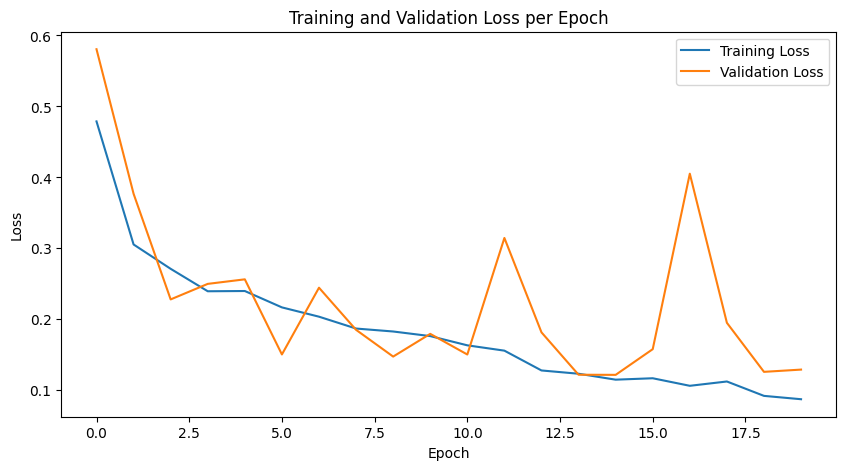

In [85]:
# Best hyperparameters from grid search
best_filters = 32
best_kernel = 3
best_dropout = 0.2
best_l2 = 0.01

# Rebuild the model using the best hyperparameters
final_model = build_cnn(num_features=X_train.shape[1],
                        filters=best_filters,
                        kernel_size=best_kernel,
                        dropout_rate=best_dropout,
                        l2_reg=best_l2)

# Optionally, compile the model with additional metrics if desired (Keras doesn't have F1 built-in)
# For now, we stick with accuracy in compile and will compute F1, recall, and precision manually.
final_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Set up callbacks for training
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the final model
history_final = final_model.fit(X_train, y_train_class,
                                validation_data=(X_test, y_test_class),
                                epochs=50,
                                batch_size=32,
                                callbacks=[early_stopping, lr_scheduler],
                                verbose=1,
                                class_weight=class_weights_dict)

# Plot training vs. validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_final.history['loss'], label='Training Loss')
plt.plot(history_final.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [86]:
# Evaluate the model on the test set for loss and accuracy
test_loss, test_accuracy = final_model.evaluate(X_test, y_test_class, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Get predictions on the test set
y_pred_probs = final_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
# Use the original labels (not one-hot encoded) for metric computations
y_true = y_test

# Compute additional metrics using scikit-learn
from sklearn.metrics import f1_score, precision_score, recall_score

f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Test Loss: 0.1218, Test Accuracy: 0.9586
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
F1 Score: 0.9689
Precision: 0.9843
Recall: 0.9586


Classification Report:
                  precision    recall  f1-score   support

    comfortable       1.00      0.95      0.97      9341
humid condition       0.97      0.99      0.98      3026
  dry condition       0.99      0.99      0.99       663
       unstable       0.19      0.90      0.32       112

       accuracy                           0.96     13142
      macro avg       0.79      0.96      0.81     13142
   weighted avg       0.98      0.96      0.97     13142

Confusion Matrix:
 [[8830   96    6  409]
 [   1 3009    0   16]
 [   3    2  658    0]
 [   4    7    0  101]]


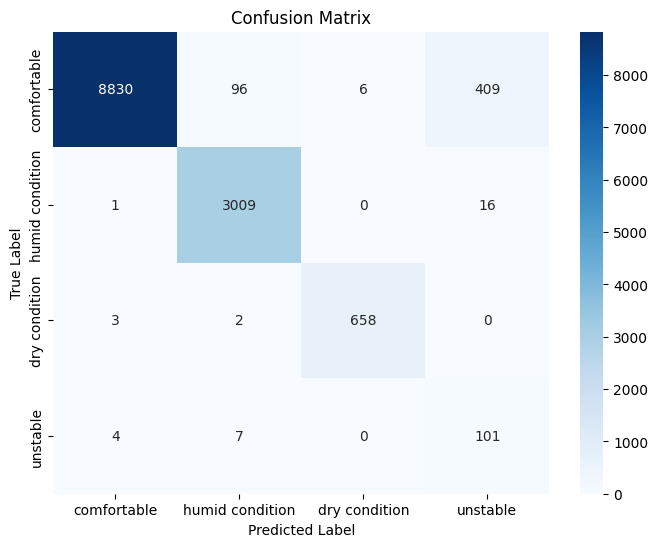

In [87]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate classification report
class_names = ["comfortable", "humid condition", "dry condition", "unstable"]
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix using seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()
